![](imagenes/UC_FMRI.jpg)

---

---

***Andres Eduardo Aracena Rangel***

*Estudiante del programa del Magister en Física Médica*

---

---


El siguiente Script de Python forma parte del trabajo especial de grado.

Profesora Guía:

*PhD María Daniela Cornejo*

---

---

&nbsp;
Con referencia:

- [Pagina oficial NIbabel](https://nipy.org/nibabel/index.html) 

Imagenes de fMRI extraidas de OpenNuero:
 
 - [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)
 
---

---

 Acronimos:

- CSF: Cerebrospinal Fluid (*líquido cefalorraquídeo*)
- GM: Gray Matter (*materia gris*)
- WM: White Matter (*materia blanca*)

---

---

NOTA:
Cuando indiquemos imagenes brain o mascaras brain, nos estamos refieriendo a las imagenes o mascaras de csf, wm, gm

---

---

# Modelos de regresión lineal múltiple en series del tejido cerebral - Normalizados

## Importamos librerias


In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj   # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)
import matplotlib.pyplot as plt   # Permite la generación de gráficos
import pandas as pd               #Biblioteca para manipulación de marcos de datos
import numpy as np
from numpy import random

#Biblioteca para estimar modelos estadísticos y realizar pruebas estadísticas
import statsmodels.api as sm

## Definimos parámetros

In [3]:
'''
Ruta donde reposan las series promedios 'brain' y 'series aleatorias' en archivo csv
'''
path_series = '/home/aracena/thesis_ds002422/04_fase2_promedio_series_tiempo_brain/output/0.95/archivos_csv/' 

'''
Ruta donde se guardaran resultados
'''
path_exp = '/home/aracena/thesis_ds002422/07_fase3_validacion_aic_regre_lin_ser_brain_norma/'
path_out = opj(path_exp, 'output')
path_png = opj(path_out, 'archivos_png')

'''
Creamos la carpeta de salida
'''
os.system('mkdir -p %s'%path_out);
os.system('mkdir -p %s'%path_png);

## Funciones

### Función para graficar series de tiempo

In [4]:
'''
Función grafica las series de tiempo de una DF introducida. Se requiere input:

- df_data = Dataframe que contiene las series de tiempo
- name_save = nombre con que desea guardar el grafico
'''

def plot_series_time(df_data, resaltar, titulo, name_save): 
    # Creamos una lista con las claves del diccionario ingresado
    tejido = list(df_data.keys())
    # definimos una ventana
    vent_min = 50
    vent_max = 75


    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, ax = plt.subplots(figsize = (17,8))
    for i,tisue in enumerate(tejido):
        if resaltar[0] == 'all':
            ax.plot(df_data[tisue], linewidth=2, label=tisue)
        elif i < len(resaltar):
            ax.plot(df_data[resaltar[i]], linewidth=2, label=tisue)
        else:           
            ax.plot(df_data[tisue], linewidth=1, label=tisue)

    ax.legend()
    ax.set_xlabel('Tiempo ($\\tau_N$)',fontdict=font1)
    ax.set_ylabel('Señal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')

    plt.savefig(opj(path_png, name_save))

### Función crear lista de las series de un DF (lista de los valores de la columna del DF) y eliminar series

In [5]:
'''
Función  que extrae una lista de los valores de las columnas de un dataframe.

Inputs:

- df: Dataframe que se desea extrae una lista de los valores de las columnas,
- elmiminar: lista de los valores de las columnas del DF que desea eliminar. Se debe ingresar una lista:
        * NO eliminar ningun valor de las columnas DF --> ['none']
        * Elimimnar uno o mas valores de la lista --> ['nombre_1' , 'nombre_2']
        
        LOS VALORES DEBE ESTAR EN FORMATO STRING (entre comillas simples o dobles)

Output:

- list_series: lista de series del DF
'''

def lista_dataframe(df, eliminar):
    # Creamos una lista de las columnas del dataframe
    series = df.columns.values
    list_series = list(series)
    
    tam = len(eliminar)

    if tam == 1:
        if eliminar[0] == 'none':
            list_series
        else:
            list_series.remove(eliminar[0]) 
    if tam != 1:   
        for i in range(tam):
            list_series.remove(eliminar[i])        
    
    return list_series    

### Función de conjunto potencia ó de número de combinaciones

En matemáticas, dado un conjunto $S$, se llama conjunto potencia o conjunto de partes de $S$ (se denota por $P(S)$ o $2^S$) al conjunto formado por todos los subconjuntos posibles de $S$.

Por ejemplo, si $S= {a, b, c}$ entonces el conjunto potencia de $S$ es 

*P(S) = {{ }, {a}, {b}, {c}, {a, b}, {a, c}, {b, c}, {a, b, c} }*

In [6]:
'''
Función para extraer todos los subconjuntos posibles de un conjunto de una lista de entrada.

Inputs:

- lista_conjunto: Lista donde se desea extraer el conjunto potencia
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- r: Lista de las combinaciones/modelos.
'''

def potencia(list_conjunto):
    '''
    Calcula y devuelve el conjunto potencia del conjunto c.
    En matemáticas, el conjunto potencia de un conjunto dado es otro conjunto 
    formado por todos los subconjuntos del conjunto dado.
    '''
   
    # Número de combinaciones
    if len(list_conjunto) == 0:
        return [[]]
    r = potencia(list_conjunto[:-1])
    
    return r + [s + [list_conjunto[-1]] for s in r]

### Funcion para crear un dataframe de las combinaciones/modelos

In [7]:
'''
Función para visualizar las combinaciones/modelos en un dataframe, para ser incorporada en documentos.

Inputs:

- lista_combi: Lista de combinaciones/modelos 
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- df_combi: Dataframe con las combinaciones/modelos
'''


def crear_df_combi(lista_combi, columnas):
    combi = lista_combi
    '''
    ordenamos la lista
    '''
    combi.sort()
    
    '''
    Se reescribe el elemento lista de la lista en un solo valor, 
    que es la combinacion/modelo
    '''

    list_combi =[]
    beta = str('$\\beta$')
    for i, co in enumerate(combi):
        modelo= beta+str(0)
        for j, mo in enumerate(combi[i]):
            modelo = modelo + ' + ' + beta + str(j+1) + ' ' + mo
        list_combi.append(modelo)   
    
    '''
    PROCESO DE CONVERTIR DE LISTA 1D A UN DATAFRAME FIL X COLUM
    '''
    # Indique cuantas columnas quiere representar las combinaciones en un DF
    colum = columnas

    # Como se quiere crear una matriz de 'colum' columnas, 
    # verifico si 'long' es divisible entre 'colum'; de no ser serlo, 
    # agrego un elemneto vacio a la lista hasta conseguirlo
    long = len(list_combi)
    n=0
    while n==0:
        if long % colum == 0: 
            n=1
        else:
            list_combi.append('')
            long = len(list_combi)
            
    # Conviertimos la lista en un array
    co = np.array(list_combi)

    # Conviertimos un array de 1D a laa dimension fil x colum
    fil = int(long/colum) # numero de filas

    co = co.reshape(fil,colum)

    # Convertirmos la matriz fil x colum en un DF
    df_combi = pd.DataFrame(co)

    '''
    Cambiamos nombre de columnas
    '''
    #Creamos lista de nuevos nombres
    new_colum = []
    for i in range(colum):
        new_colum.append('Combinaciones / Modelos')

    df_combi.columns = new_colum

    '''
    Renombramos indice
    '''
    #Creamos diccionario de nuevos indices
    new_index = {}
    for i in range(fil):
        new_index[i]= ' '

    #renombramos indices
    df_combi.rename(index=new_index, inplace=True)
    
    return df_combi    

In [8]:
'''
Función para visualizar las combinaciones/modelos en un dataframe, para ser incorporada en documentos.

Inputs:

- lista_combi: Lista de combinaciones/modelos 
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- df_combi: Dataframe con las combinaciones/modelos
'''


def crear_df_combi_1(lista_combi, columnas):
    '''
    ordenamos la lista
    '''
    combi.sort()
    
    '''
    Se reescribe el elemento lista de la lista en un solo valor, 
    que es la combinacion/modelo
    '''
    le = len(combi)
    list_combi =[]
    for i, co in enumerate(combi):
        ser = co
        w = len(ser)
        for i, se in enumerate(ser):
            if i == 0:
                agr = se
            else:
                agr = agr + ' + ' + se
        list_combi.append(agr)
        
    '''
    PROCESO DE CONVERTIR DE LISTA 1D A UN DATAFRAME FIL X COLUM
    '''
    # Indique cuantas columnas quiere representar las combinaciones en un DF
    colum = columnas

    # Como se quiere crear una matriz de 'colum' columnas, 
    # verifico si 'long' es divisible entre 'colum'; de no ser serlo, 
    # agrego un elemneto vacio a la lista hasta conseguirlo
    long = len(list_combi)
    n=0
    while n==0:
        if long % colum == 0: 
            n=1
        else:
            list_combi.append('')
            long = len(list_combi)
            
    # Conviertimos la lista en un array
    co = np.array(list_combi)

    # Conviertimos un array de 1D a laa dimension fil x colum
    fil = int(long/colum) # numero de filas

    co = co.reshape(fil,colum)

    # Convertirmos la matriz fil x colum en un DF
    df_combi = pd.DataFrame(co)

    '''
    Cambiamos nombre de columnas
    '''
    #Creamos lista de nuevos nombres
    new_colum = []
    for i in range(colum):
        new_colum.append('Combinaciones / Modelos')

    df_combi.columns = new_colum

    '''
    Renombramos indice
    '''
    #Creamos diccionario de nuevos indices
    new_index = {}
    for i in range(fil):
        new_index[i]= ' '

    #renombramos indices
    df_combi.rename(index=new_index, inplace=True)
    
    return df_combi    

### Función aplicacion modelo OLS

In [9]:
'''
df_analisis: Dataframe que contien la serie dependiente (variable dependiente o variable de respuesta)
                y las series predictoras (ariables independientes o variables predictoras)
var_depen: Variable dependiente del dataframe (serie a predecir)
modelo: modelo a predecir la variable dependiente

Output: 

aic, r2, r2_adj, model: estadistios
'''


def estadisticos(df_analisis, var_depen, modelo):
    # Y: normalmente significa la variable respuesta (variable dependiente o variable de respuesta)
    #define response variable
    Y = df_analisis[var_depen]

    # X: usualmente significa nuestras variables de entrada (variables independientes o variables predictoras)
    X = df_analisis[modelo]

    #agregar constante a las variables predictoras [intercepción (beta_0) al modelo]
    X = sm.add_constant(X)

    #ajustamos modelo de regresión
    model = sm.OLS(Y, X).fit()    # sm.OLS(respuesta, entrada)

    #guardamos estadisticos AIC, R2, R2-AJUSTADO
    aic = model.aic
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    
    return aic, r2, r2_adj, model

### Función para determinar el mejor modelo mediante modelo de regresión OSL

In [10]:
def best_osl(df_depen, df_indep, var_depen, lista_combi):
    num_ser = df_depen.shape[1]

    a = pd.DataFrame()
    b = pd.DataFrame()
    aa = pd.DataFrame()
    bb = pd.DataFrame()
    aaa = pd.DataFrame()
    bbb = pd.DataFrame()
    for i in range(num_ser):
        #creamos una lista que identifica la serie del voxel, con la camtidad de combinaciones
        serie = []
        for j in enumerate(lista_combi):
            serie.append(i)
        #se crea dataframe que identifica voxel en estudio
        df_serie = pd.DataFrame(serie, columns=['serie'])

        #extraemos la serie de tiempo del voxel i
        serie_estudio = df_depen.iloc[:,[i]]
        serie_estudio.columns=[var_depen]

        analisis = pd.merge(serie_estudio, df_indep,
                               right_index=True,left_index=True)

        #Ejecutamos la funcion aic
        RESULTADO_AIC = {}
        RESULTADO_R2 = {}
        RESULTADO_R2_AJU = {}
        modelo = {}
        for i, c in enumerate(lista_combi):
            li = lista_combi[i]
            anali = estadisticos(df_analisis=analisis,
                                 var_depen= var_depen,
                                 modelo=li)
            AIC = round(anali[0],2)
            R2 = round(anali[1],4)
            R2_AJU = round(anali[2],4)        
            c = ','.join(c)
            RESULTADO_AIC[c] = AIC
            RESULTADO_R2[c] = R2
            RESULTADO_R2_AJU[c] = R2_AJU
            modelo[c] = anali[3]


        '''
        DataFrame AIC
        '''
        #representamos el resultado aic en un dataframe
        DF_AIC = pd.DataFrame(list(RESULTADO_AIC.items()),
                       columns=['MODELO', 'AIC'])

        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_AIC = pd.merge(DF_AIC,DF_MODELO, on='MODELO')

        #ordenamos de mayor a menor
        DFM_AIC = DF_AIC.sort_values('AIC')

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_AIC.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_aic = pd.merge(df_serie, DFM_AIC,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_aic = best_model_aic.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            a = best_model_aic
            b = best_aic
        else:
            best_model_aic = pd.concat([a, best_model_aic])
            best_aic = pd.concat([b, best_aic])
            a = best_model_aic
            b = best_aic

        #restablecer el índice
        best_model_aic.reset_index(drop=True, inplace=True)
        best_aic.reset_index(drop=True, inplace=True)


        '''
        DataFrame R2
        '''

        #representamos el resultado aic en un dataframe
        DF_R2 = pd.DataFrame(list(RESULTADO_R2.items()),
                       columns=['MODELO', 'R2'])
        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO_R2 = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_R2 = pd.merge(DF_R2,DF_MODELO_R2, on='MODELO')


        #ordenamos de mayor a menor
        DFM_R2 = DF_R2.sort_values('R2',ascending=False)

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_R2.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_r2 = pd.merge(df_serie, DFM_R2,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_r2 = best_model_r2.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            aa = best_model_r2
            bb = best_r2
        else:
            best_model_r2 = pd.concat([aa, best_model_r2])
            best_r2 = pd.concat([bb, best_r2])
            aa = best_model_r2
            bb = best_r2

        #restablecer el índice
        best_model_r2.reset_index(drop=True, inplace=True)
        best_r2.reset_index(drop=True, inplace=True)


        '''
        DataFrame R2-ajustado
        '''
        #representamos el resultado aic en un dataframe
        DF_R2_AJU = pd.DataFrame(list(RESULTADO_R2_AJU.items()),
                       columns=['MODELO', 'R2-ajus'])

        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO_R2_AJU = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_R2_AJU= pd.merge(DF_R2_AJU,DF_MODELO_R2_AJU, on='MODELO')

        #ordenamos de mayor a menor
        DFM_R2_AJU = DF_R2_AJU.sort_values('R2-ajus',ascending=False)

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_R2_AJU.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_aju = pd.merge(df_serie, DFM_R2_AJU,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_r2_aju = best_model_aju.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            aaa = best_model_aju
            bbb = best_r2_aju
        else:
            best_model_aju = pd.concat([aaa, best_model_aju])
            best_r2_aju = pd.concat([bbb, best_r2_aju])
            aaa = best_model_aju
            bbb = best_r2_aju

        #restablecer el índice
        best_model_aju.reset_index(drop=True, inplace=True)
        best_r2_aju.reset_index(drop=True, inplace=True)

    return  best_aic, best_model_aic, best_r2, best_model_r2, best_r2_aju, best_model_aju, 
    #print(DFM_R2)
    #print('\n',best_model)
    #print('\n', best_aic)

### Función para extraer los valores p de los regresores

In [11]:
'''
Función para extraer los valores p de las variables regresoras y su analisis con respecto al nivel 
significancia. Se requiere como inputs:

- df_ana = DF que se desea analisar y que debe contener los resultados de la regresión lineal
- nivel_signif = Nivel de significancia, si es de 5%, ingresamos 0.05, 
                                         si es del 10%, ingresamos 0.1, etc

Como output obtendremos un DF con el analisis sobre el valor p en los regresores
'''


def analisi_p(df_anali, nivel_signif):
    import pandas as pd
    '''
    Extraemos el primer indice de la DF a analizar. Esto se realiza, ya que en el analisis podremos escojer 
    los mejores aic de un conjunto de series que no empiece en el voxel/serie cero, por ejemplo, 
    puedo escojer los voxels del valor 4865 al 9728 que corresponden al segundo corte, y si utilizamos 
    el ciclo for desde 0, nos cambiara la identificación del voxel para para ser ingresado a la DF; 
    por ejemplo, el primer voxel al pasar por el ciclo es el 4865, y el ciclo lo guaradara 
    como 0
    '''

    inicio = df_anali.index.start

    '''
    Extraemos los valores p
    '''
    tam = len(df_anali)

    df_coef = pd.DataFrame()
    df_suma = pd.DataFrame()
    for i in range(tam):
        #extraemos resultados de la regresión lineal (RL) de las series de la imagen
        best_model = df_anali['resultado_regresión'][i+inicio]     
        indice = inicio + i
        #creamos DF de los valores p de la RL de la serie
        df_co = pd.DataFrame(round(best_model.pvalues,2)).T
        df_co.index = [indice]    

        #concatenamos
        df_coef = pd.concat([df_coef,df_co])

        #extraemos nombre de las columnas (regresores) en una lista; se extraee de la lista antes de concaenar
        regresores = df_co.columns.values  
        list_regresor = list(regresores)

        suma_evaluacion = 0
        valores_p = [] # creamos una lista para guardar los valores p y luego anexarla al DF best_aic

        for i, re in enumerate(list_regresor):
            coef = df_coef[re][indice]
            if coef < nivel_signif:
                suma_evaluacion = suma_evaluacion
            else:
                suma_evaluacion = suma_evaluacion + 1

            valores_p.append(coef)

        '''
        Agregamos el resultado de la lista de valores p de los regresores y 
        la suma_evaluación al DF en evaluación
        '''
        df_su = pd.DataFrame()
        df_su['valores_p_regresores'] = [valores_p]
        df_su['suma_evaluación'] = [suma_evaluacion]
        df_su.index = [indice]

        # concatenamos
        df_suma = pd.concat([df_suma,df_su])

    '''
    Unimos en un DF el resultado final
    '''
    analisis_p = pd.merge(df_coef, df_suma,
                       right_index=True,left_index=True)
    '''
    Unimos con la DF analisi_p con la DF de entrada
    '''
    best_p_1 = pd.merge(df_anali, analisis_p,
                           right_index=True,left_index=True)

    # eliminamos la columna resultado_regresión, 
    best_p = best_p_1.drop(['resultado_regresión'], axis=1)
    
    '''
    Crearemos un DF donde anexaremos una nueva columna, donde al evaluar suma_evaluacion si es 0, 
    agregamos el modelo AIC, si es mayor a cero, agregamos la palabra 'Pout', indicandonos que el
    modelo iene un valor p matyor a 0.05
    '''
    modelo_p = pd.DataFrame()

    for i in range(tam):
        valeva = best_p['suma_evaluación'][i+inicio]

        model_p = pd.DataFrame()
        if valeva == 0:
            model_p['MODELO_P'] = [best_p['MODELO'][i+inicio]]
        else:
            model_p['MODELO_P'] = ['Pout']

        model_p.index = [i+inicio]
        modelo_p = pd.concat([modelo_p,model_p])
    '''
    UNIMOS DF
    '''
    df_anali_p = pd.merge(best_p, modelo_p,
                     right_index=True,left_index=True)
    
    return df_anali_p

In [12]:
'''
Función para extraer los valores p de las variables regresoras y su analisis con respecto al nivel 
significancia. Se requiere como inputs:

- df_ana = DF que se desea analisar y que debe contener los resultados de la regresión lineal
- nivel_signif = Nivel de significancia, si es de 5%, ingresamos 0.05, 
                                         si es del 10%, ingresamos 0.1, etc

Como output obtendremos un DF con el analisis sobre el valor p en los regresores
'''


def analisi_p_1(df_anali, nivel_signif):
    import pandas as pd
    '''
    Extraemos el primer indice de la DF a analizar. Esto se realiza, ya que en el analisis podremos escojer 
    los mejores aic de un conjunto de series que no empiece en el voxel/serie cero, por ejemplo, 
    puedo escojer los voxels del valor 4865 al 9728 que corresponden al segundo corte, y si utilizamos 
    el ciclo for desde 0, nos cambiara la identificación del voxel para para ser ingresado a la DF; 
    por ejemplo, el primer voxel al pasar por el ciclo es el 4865, y el ciclo lo guaradara 
    como 0
    '''

    inicio = df_anali.index.start

    '''
    Extraemos los valores p
    '''
    tam = len(df_anali)

    df_coef = pd.DataFrame()
    df_suma = pd.DataFrame()
    for i in range(tam):
        #extraemos resultados de la regresión lineal (RL) de las series de la imagen
        best_model = df_anali['resultado_regresión'][i+inicio]     
        indice = inicio + i
        #creamos DF de los valores p de la RL de la serie
        df_co = pd.DataFrame(round(best_model.pvalues,2)).T
        df_co.index = [indice]   

        #concatenamos
        df_coef = pd.concat([df_coef,df_co])

        #extraemos nombre de las columnas (regresores) en una lista; se extrae de la lista antes de concaenar
        regresores = df_co.columns.values  
        list_regresor = list(regresores)

        suma_evaluacion = 0
        valores_p = [] # creamos una lista para guardar los valores p y luego anexarla al DF best_aic
        
        # El la evaluación, no tomamos en cuenta el valor p de la constante
        for i in range(len(list_regresor)-1):            
            coef = df_coef[list_regresor[i+1]][indice]
            if coef < nivel_signif:
                suma_evaluacion = suma_evaluacion
            else:
                suma_evaluacion = suma_evaluacion + 1

            valores_p.append(coef)

        '''
        Agregamos el resultado de la lista de valores p de los regresores y 
        la suma_evaluación al DF en evaluación
        '''
        df_su = pd.DataFrame()
        df_su['valores_p_regresores_ser'] = [valores_p]
        df_su['suma_evaluación'] = [suma_evaluacion]
        df_su.index = [indice]

        # concatenamos
        df_suma = pd.concat([df_suma,df_su])

    '''
    Unimos en un DF el resultado final
    '''
    analisis_p = pd.merge(df_coef, df_suma,
                       right_index=True,left_index=True)
    '''
    Unimos con la DF analisi_p con la DF de entrada
    '''
    best_p_1 = pd.merge(df_anali, analisis_p,
                           right_index=True,left_index=True)

    # eliminamos la columna resultado_regresión, 
    best_p = best_p_1.drop(['resultado_regresión'], axis=1)
    
    '''
    Crearemos un DF donde anexaremos una nueva columna, donde al evaluar suma_evaluacion si es 0, 
    agregamos el modelo AIC, si es mayor a cero, agregamos la palabra 'Pout', indicandonos que el
    modelo iene un valor p matyor a 0.05
    '''
    modelo_p = pd.DataFrame()

    for i in range(tam):
        valeva = best_p['suma_evaluación'][i+inicio]

        model_p = pd.DataFrame()
        if valeva == 0:
            model_p['MODELO_P'] = [best_p['MODELO'][i+inicio]]
        else:
            model_p['MODELO_P'] = ['Pout']

        model_p.index = [i+inicio]
        modelo_p = pd.concat([modelo_p,model_p])
    '''
    UNIMOS DF
    '''
    df_anali_p = pd.merge(best_p, modelo_p,
                     right_index=True,left_index=True)
    
    return df_anali_p

### Función para graficar la variable dependiente en un modelo de OSL y el resultado del mejor modelo

In [13]:
'''
Función para graficar la variable dependiente en un modelo de OSL y el resultado del mejor modelo 
mediante modelo de regresión OSL.

Inputs:

- df_depen = Dataframe de la variable dependiente del modelo de OSL 
- models_osl = Dataframe de los modelos de regresion al aplicar la funcion 'best_osl'. Ingresar solo
                el resultado segun alguno de los estadistico de AIC, R2 o R2_adjustado.
- best = seleccionar el modelo que quiere graficar. Si desea graficar el mejor modelo, se ingresa 0; 
        si desea graficar el segundo mejor modelo, se ingresa 1, y asi sucesivamente.
- titulo = titulo de la grafica
- name_save = nombre con el que se desea guardar la grafica
'''

def plot_series_osl(df_depen, models_osl, best, titulo, name_save): 
    '''
    Elegimos el modelo segun variable input best
    '''
    best_model= models_osl['resultado_regresión'][best]
    print(best_model.summary())
    
    '''
    Crear la etiqueta del mejor modelo
    '''

    for i, mo in enumerate(models_osl['MODELO'][best]):
        mo=models_osl['MODELO'][best].split(',') #Split regresa una lista de las palabras en la cadena, 
                                 # usando separador como el delimitador.

    '''
    Creamos nombre con los coeficientes y series del mejor modelo
    '''
    beta = str('$\\beta$')
    modelo_win = df_depen.columns.values[0]+' = '+beta+str(0)
    for i, m in enumerate(mo):
        modelo_win = modelo_win + ' + ' + beta + str(i+1) + m 
    
    '''
    Creamos etiqueta de la variable dependiente
    '''
    label_depen = df_depen.columns.values
    label_depen = label_depen[0]
    
    '''
    Dataframe del modelo de regresion OSL
    '''
    df_osl = pd.DataFrame(best_model.fittedvalues)
    df_osl.columns = ['modelo OLS']    
    
    # definimos una ventana
    vent_min = 50
    vent_max = 75


    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, ax = plt.subplots(figsize = (17,8))
    ax.plot(df_depen, linewidth=2, label=label_depen)
    ax.plot(df_osl, '--.', linewidth=2, color = 'red', label=modelo_win)

    ax.legend()
    ax.set_xlabel('Tiempo ($\\tau_N$)',fontdict=font1)
    ax.set_ylabel('Señal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')

    plt.savefig(opj(path_png, name_save))

### Función para comparar los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [14]:
'''
Función que genera un dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado.

Inputs:

aic = DF modelos segun el estadistico AIC (DF resultante de la funcion 'best_osl')
r2 = DF modelos segun el estadistico R2 (DF resultante de la funcion 'best_osl')
r2_ajus = DF modelos segun el estadistico R2_ajus (DF resultante de la funcion 'best_osl')
'''

def compara_models_estad(aic,r2,r2_ajus):
    df_aic_best = aic_all.copy()
    df_aic_best = df_aic_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df_r2_best = r2_all.copy()
    df_r2_best = df_r2_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df_r2_aju_best = r2_ajus_all.copy()
    df_r2_aju_best = df_r2_aju_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df4 = pd.merge(df_aic_best,df_r2_best,on='MODELO',how='left')
    df5 = pd.merge(df4,df_r2_aju_best,on='MODELO',how='left')

    df5.style.highlight_max(axis=0)
    
    return     df5.style.\
                    highlight_max(subset=['AIC'], color='salmon').\
                    highlight_min(subset=['AIC'], color='yellow').\
                    highlight_max(subset=['R2','R2-ajus'], color='yellow').\
                    highlight_min(subset=['R2','R2-ajus'], color='salmon').\
                    format({'id':'{:.0f}'})
    

## Cargamos las series promedio global CSF, GM y WM.

In [15]:
'''
Cargamos la serie del csf
'''
df_csf = pd.read_csv (opj(path_series,'serie_tiempo_norm_prom_ser_csf_norm.csv'))

'''
Cargamos la serie del gm
'''
df_gm = pd.read_csv (opj(path_series,'serie_tiempo_norm_prom_ser_gm_norm.csv'))


'''
Cargamos la serie del wm
'''
df_wm = pd.read_csv (opj(path_series,'serie_tiempo_norm_prom_ser_wm_norm.csv'))

'''
Unimos series csf, gm y wm en un dataframe
'''
df_series_brain = pd.merge(df_csf,df_gm,right_index=True,left_index=True)
df_series_brain = pd.merge(df_series_brain,df_wm,right_index=True,left_index=True)

df_series_brain.round(3)

,ser_csf_norm,ser_gm_norm,ser_wm_norm
0,0.659,0.691,0.593
1,0.606,0.594,0.608
2,0.676,0.560,0.569
3,0.413,0.408,0.334
4,0.499,0.591,0.417
...,...,...,...
191,0.718,0.687,0.608
192,0.720,0.512,0.551
193,0.633,0.561,0.651
194,0.731,0.673,0.751


### Extraemos la media de las series  *brain* 

In [16]:
df_mean = pd.DataFrame(df_series_brain.mean())
df_mean.columns = ['mean']
df_mean.round(3)

,mean
ser_csf_norm,0.631
ser_gm_norm,0.586
ser_wm_norm,0.590


### Creamos dataframe para graficar las series brain con la media

In [17]:
df_mean_csf = pd.DataFrame()

In [18]:
df_mean_csf = pd.DataFrame(columns = ['mean_csf'])

for i in range(df_series_brain['ser_csf_norm'].shape[0]):
    df_mean_csf = df_mean_csf.append({'mean_csf':df_mean['mean']['ser_csf_norm']},                
                   ignore_index = True) 
df_mean_csf

,mean_csf
0,0.63076
1,0.63076
2,0.63076
3,0.63076
4,0.63076
...,...
191,0.63076
192,0.63076
193,0.63076
194,0.63076


In [19]:
df_mean_gm = pd.DataFrame(columns = ['mean_gm'])

for i in range(df_series_brain['ser_gm_norm'].shape[0]):
    df_mean_gm = df_mean_gm.append({'mean_gm':df_mean['mean']['ser_gm_norm']},                
                   ignore_index = True) 
df_mean_gm

,mean_gm
0,0.586474
1,0.586474
2,0.586474
3,0.586474
4,0.586474
...,...
191,0.586474
192,0.586474
193,0.586474
194,0.586474


In [20]:
df_mean_wm = pd.DataFrame(columns = ['mean_wm'])

for i in range(df_series_brain['ser_wm_norm'].shape[0]):
    df_mean_wm = df_mean_wm.append({'mean_wm':df_mean['mean']['ser_wm_norm']},                
                   ignore_index = True) 
df_mean_wm

,mean_wm
0,0.590313
1,0.590313
2,0.590313
3,0.590313
4,0.590313
...,...
191,0.590313
192,0.590313
193,0.590313
194,0.590313


In [21]:
'''
Unimos con dDF df_series_brain
'''

df_mean_brains = pd.merge(df_mean_csf,df_mean_gm,right_index=True,left_index=True)
df_mean_brains = pd.merge(df_mean_brains,df_mean_wm,right_index=True,left_index=True)

df_series_brain_and_mean = pd.merge(df_series_brain,df_mean_brains,right_index=True,left_index=True)
df_series_brain_and_mean

,ser_csf_norm,ser_gm_norm,ser_wm_norm,mean_csf,mean_gm,mean_wm
0,0.659252,0.690649,0.592850,0.63076,0.586474,0.590313
1,0.605535,0.593822,0.607634,0.63076,0.586474,0.590313
2,0.676476,0.559598,0.569410,0.63076,0.586474,0.590313
3,0.413124,0.407866,0.334294,0.63076,0.586474,0.590313
4,0.499224,0.590816,0.416812,0.63076,0.586474,0.590313
...,...,...,...,...,...,...
191,0.718453,0.686644,0.607888,0.63076,0.586474,0.590313
192,0.720197,0.511550,0.550751,0.63076,0.586474,0.590313
193,0.632843,0.560688,0.650929,0.63076,0.586474,0.590313
194,0.731416,0.673054,0.751453,0.63076,0.586474,0.590313


### Visualizamos las series  promedio global y sus medias

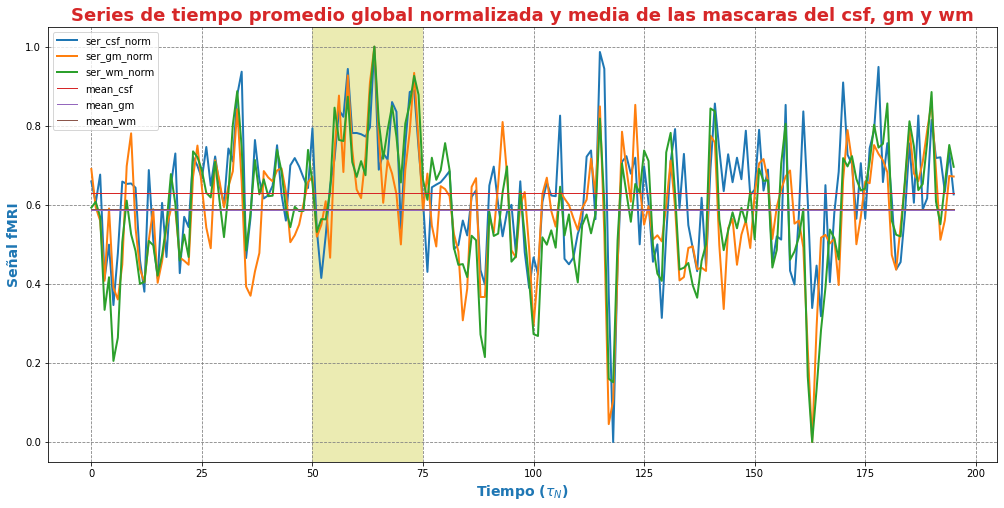

In [22]:
plot_series_time(df_data=df_series_brain_and_mean, 
                 resaltar=['ser_csf_norm', 'ser_gm_norm', 'ser_wm_norm'], 
                 titulo='Series de tiempo promedio global normalizada y media de las mascaras del csf, gm y wm', 
                 name_save='serie_suma_resultado_random.png')

## Validación 9 / Regresión Lineal de series brain

Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la serie promedio global de la GM (*ser_mask_gm*), en esta primera validación tomamos en cuenta la serie promedio global de la CSF y WM (*ser_mask_csf* y *ser_mask_wm*) para la construcción de los modelos.

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [23]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_series_brain,
                           eliminar=['ser_gm_norm'])

list_ser

['ser_csf_norm', 'ser_wm_norm']

#### Combinaciones de las series para generar ser_tiem_sum

In [24]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[], ['ser_csf_norm'], ['ser_wm_norm'], ['ser_csf_norm', 'ser_wm_norm']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [25]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_csf_norm'], ['ser_wm_norm'], ['ser_csf_norm', 'ser_wm_norm']] 


cantidad de combinaciones/modelos:

 3


#### Generamos un DF de las combinaciones/modelos para un documento

In [26]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 1)

,Combinaciones / Modelos
,$\beta$0 + $\beta$1 ser_csf_norm
,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_wm_norm
,$\beta$0 + $\beta$1 ser_wm_norm


### Aplicamos el modelo OLS

In [27]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_series_brain.drop(['ser_gm_norm'], axis=1)
df_ser_indep

,ser_csf_norm,ser_wm_norm
0,0.659252,0.592850
1,0.605535,0.607634
2,0.676476,0.569410
3,0.413124,0.334294
4,0.499224,0.416812
...,...,...
191,0.718453,0.607888
192,0.720197,0.550751
193,0.632843,0.650929
194,0.731416,0.751453


#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [28]:
modelo_regre = best_osl(df_depen=df_gm, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_gm_norm',
                        lista_combi=combi)

In [29]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [30]:
mejor_aic

,serie,MODELO,AIC,resultado_regresión
0,0,ser_wm_norm,-417.06,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fbb7ffbed60>


In [31]:
pd.set_option('display.max_colwidth', 60)
aic_all

,serie,MODELO,AIC,resultado_regresión
0,0,ser_wm_norm,-417.06,<statsmodels.regression.linear_model.RegressionResultsWr...
1,0,"ser_csf_norm,ser_wm_norm",-415.41,<statsmodels.regression.linear_model.RegressionResultsWr...
2,0,ser_csf_norm,-289.42,<statsmodels.regression.linear_model.RegressionResultsWr...


#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [32]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

,serie,MODELO,AIC,const,ser_wm_norm,valores_p_regresores,suma_evaluación,MODELO_P
0,0,ser_wm_norm,-417.06,0.0,0.0,"[0.0, 0.0]",0,ser_wm_norm


#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:            ser_gm_norm   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     422.9
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           1.28e-50
Time:                        11:02:58   Log-Likelihood:                 210.53
No. Observations:                 196   AIC:                            -417.1
Df Residuals:                     194   BIC:                            -410.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1433      0.022      6.412      

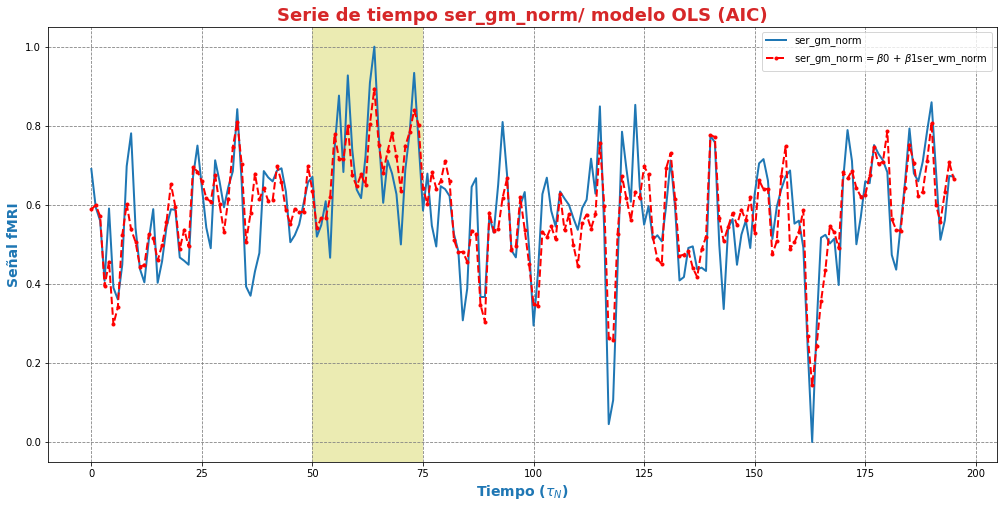

In [33]:
plot_series_osl(df_depen=df_gm, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo ser_gm_norm/ modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del segundo mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:            ser_gm_norm   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     210.9
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           2.80e-49
Time:                        11:02:59   Log-Likelihood:                 210.70
No. Observations:                 196   AIC:                            -415.4
Df Residuals:                     193   BIC:                            -405.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1352      0.026      5.118   

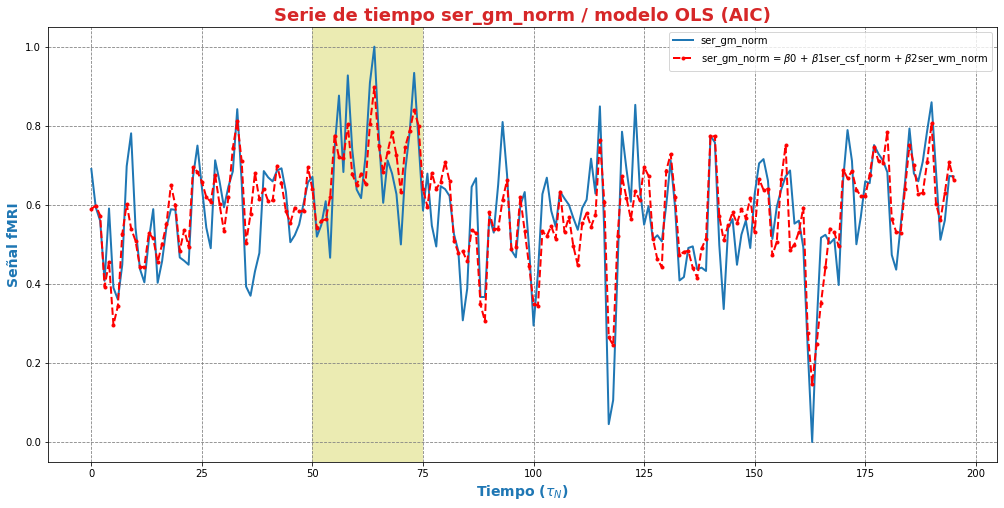

In [34]:
plot_series_osl(df_depen=df_gm, 
                models_osl=aic_all, 
                best=1, 
                titulo='Serie de tiempo ser_gm_norm / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del tercer mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:            ser_gm_norm   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     127.6
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           4.56e-23
Time:                        11:02:59   Log-Likelihood:                 146.71
No. Observations:                 196   AIC:                            -289.4
Df Residuals:                     194   BIC:                            -282.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1896      0.036      5.254   

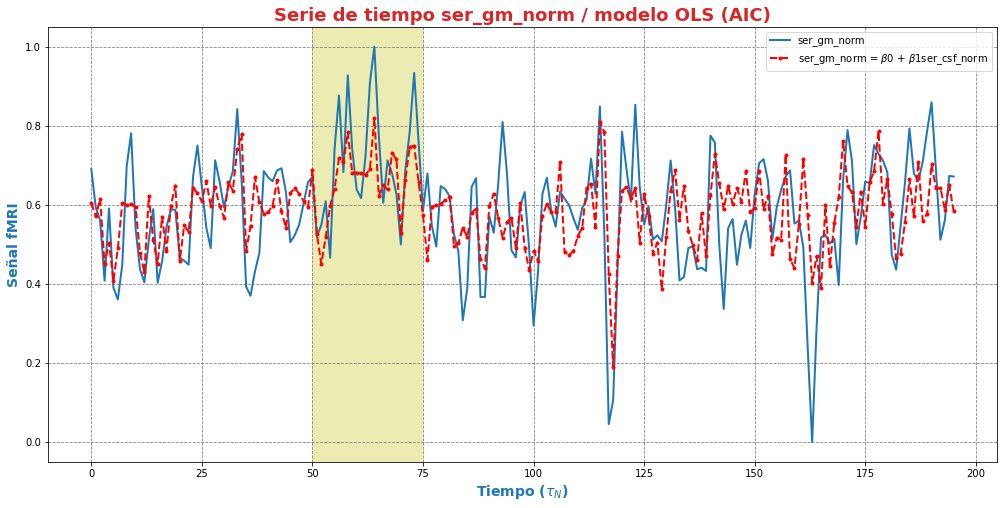

In [35]:
plot_series_osl(df_depen=df_gm, 
                models_osl=aic_all, 
                best=2, 
                titulo='Serie de tiempo ser_gm_norm / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [36]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

,MODELO,AIC,R2,R2-ajus
0,ser_wm_norm,-417.060000,0.685500,0.683900
1,"ser_csf_norm,ser_wm_norm",-415.410000,0.686000,0.682800
2,ser_csf_norm,-289.420000,0.396800,0.393700


## Validación 10 / Regresión Lineal de series brain


Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la seunda Validación, usaremos la data de *df_series_brain*, y agregamos cuatro series aleatorias.

Ahora vamos a 'contaminar' nuestros datos, agregando cuatro series aletorias que n parte de los modelos. Las series contaminantes del 13 al 15 (*ser_cont_13* al *ser_cont_15*) se encontraran entre *ser_mask_csf* y *ser_mask_wm* y la serie contamiante 16 cerca de la linea base (0).

### Generamos series aleatorias contaminantes 13, 14, 15 y 16.

In [37]:
'''
Generamos tres series aletorias entre ser_mask_csf y ser_mask_wm. Su ibicación o media de series
aletorias se genera tambien aleatoriamente entre la media de ser_mask_csf y ser_mask_wm.
'''

# Generamos las medias aleatorias
np.random.seed(91011)
mean_random = np.random.uniform(low=df_mean['mean']['ser_wm_norm'], 
                                high=df_mean['mean']['ser_csf_norm'], 
                                size=3).tolist()


# Generamos las series entre  ser_mask_csf y ser_mask_wm.
mean_ser_cont_13 = mean_random[0]

ser_cont_13 = np.random.uniform(low= mean_ser_cont_13 - 0.3, 
                               high=mean_ser_cont_13 + 0.3, 
                               size=df_series_brain['ser_csf_norm'].shape[0]).tolist()


mean_ser_cont_14 = mean_random[1]

ser_cont_14 = np.random.uniform(low= mean_ser_cont_14 - 0.3, 
                               high=mean_ser_cont_14 + 0.3, 
                               size=df_series_brain['ser_csf_norm'].shape[0]).tolist()

mean_ser_cont_15 = mean_random[2]

ser_cont_15 = np.random.uniform(low= mean_ser_cont_15 -0.3, 
                               high=mean_ser_cont_15 + 0.3, 
                               size=df_series_brain['ser_csf_norm'].shape[0]).tolist()

'''
Generamos serie aletoria entre ser_la base (0) y ser_mask_gm. Su ubicación o media de la serie
aletoria se genera tambien aleatoriamente entre 0 y ser_mask_gm.
'''
np.random.seed(400)
mean_ser_cont_16 = np.random.uniform(low=0, 
                                     high=1, 
                                     size=1).tolist()

ser_cont_16 = np.random.uniform(low= mean_ser_cont_16[0] - 0.3, 
                               high=mean_ser_cont_16[0] + 0.3, 
                               size=df_series_brain['ser_csf_norm'].shape[0]).tolist()


In [38]:
'''
Creamos DF de las series aleatorias contaminantes
'''
df_sr_con_13 = pd.DataFrame(ser_cont_13, columns=['ser_cont_13'])
df_sr_con_14 = pd.DataFrame(ser_cont_14, columns=['ser_cont_14'])
df_sr_con_15 = pd.DataFrame(ser_cont_15, columns=['ser_cont_15'])
df_sr_con_16 = pd.DataFrame(ser_cont_16, columns=['ser_cont_16'])

'''
Unimos DFs en una sola
'''
df_sr_conta_sub1 = pd.merge(df_sr_con_13, df_sr_con_14, right_index=True, left_index=True)
df_sr_conta_sub2 = pd.merge(df_sr_con_15, df_sr_con_16, right_index=True, left_index=True)

df_sr_conta = pd.merge(df_sr_conta_sub1, df_sr_conta_sub2, right_index=True, left_index=True)

df_sr_conta.round(3)

,ser_cont_13,ser_cont_14,ser_cont_15,ser_cont_16
0,0.769,0.810,0.326,0.504
1,0.499,0.608,0.640,0.884
2,0.637,0.710,0.372,0.543
3,0.760,0.875,0.516,0.458
4,0.475,0.702,0.407,0.376
...,...,...,...,...
191,0.326,0.311,0.867,0.572
192,0.576,0.753,0.419,0.757
193,0.391,0.901,0.760,0.841
194,0.465,0.779,0.679,0.931


### Unimos series contaminantes con el dataframe de las series de prueba

In [39]:
df_valida_8 = pd.merge(df_series_brain, df_sr_conta, right_index=True, left_index=True)
df_valida_8.round(3)

,ser_csf_norm,ser_gm_norm,ser_wm_norm,ser_cont_13,ser_cont_14,ser_cont_15,ser_cont_16
0,0.659,0.691,0.593,0.769,0.810,0.326,0.504
1,0.606,0.594,0.608,0.499,0.608,0.640,0.884
2,0.676,0.560,0.569,0.637,0.710,0.372,0.543
3,0.413,0.408,0.334,0.760,0.875,0.516,0.458
4,0.499,0.591,0.417,0.475,0.702,0.407,0.376
...,...,...,...,...,...,...,...
191,0.718,0.687,0.608,0.326,0.311,0.867,0.572
192,0.720,0.512,0.551,0.576,0.753,0.419,0.757
193,0.633,0.561,0.651,0.391,0.901,0.760,0.841
194,0.731,0.673,0.751,0.465,0.779,0.679,0.931


#### Damos un formato a las DF solo para ser extraidas a un documento

In [40]:
df_1 = df_valida_8.copy()

new_index = df_1.index+1

nomb_colum = df_1.columns.values

header = pd.MultiIndex.from_product([['Series de tiempo: '], nomb_colum],
                                    names=[' ','tiempo ($\\tau_N$)'])
df_1 = pd.DataFrame(df_1.values, columns=header, index=new_index)

display(df_1.round(3))

Series de tiempo:                                       \
tiempo ($\tau_N$)       ser_csf_norm ser_gm_norm ser_wm_norm ser_cont_13   
1                              0.659       0.691       0.593       0.769   
2                              0.606       0.594       0.608       0.499   
3                              0.676       0.560       0.569       0.637   
4                              0.413       0.408       0.334       0.760   
5                              0.499       0.591       0.417       0.475   
..                               ...         ...         ...         ...   
192                            0.718       0.687       0.608       0.326   
193                            0.720       0.512       0.551       0.576   
194                            0.633       0.561       0.651       0.391   
195                            0.731       0.673       0.751       0.465   
196                            0.626       0.672       0.696       0.807   

                                                       
tiempo ($\tau_N$) ser_cont_14 ser_cont_15 ser_cont_16  
1                       0.810       0.326       0.504  
2                       0.608       0.640       0.884  
3                       0.710       0.372       0.543  
4                       0.875       0.516       0.458  
5                       0.702       0.407       0.376  
..                        ...         ...         ...  
192                     0.311       0.867       0.572  
193                     0.753       0.419       0.757  
194                     0.901       0.760       0.841  
195                     0.779       0.679       0.931  
196                     0.870       0.872       0.606  

[196 rows x 7 columns]

### Graficamos las series

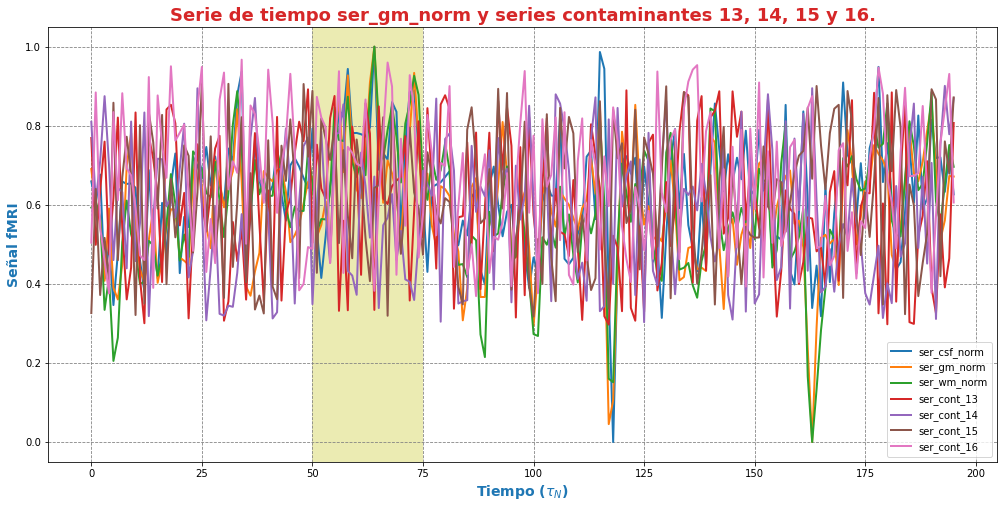

In [41]:
plot_series_time(df_data=df_valida_8, 
                 resaltar=['all'], 
                 titulo='Serie de tiempo ser_gm_norm y series contaminantes 13, 14, 15 y 16.', 
                 name_save='serie_suma_serie_conta?valida_2.png')

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la seria suma (*ser_sum*), en esta primera validación (asi como en las posteriores) no tomamos en cuenta en el modelo la serie error (*error*).

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [42]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_valida_8,
                           eliminar=['ser_gm_norm'])

list_ser

['ser_csf_norm',
 'ser_wm_norm',
 'ser_cont_13',
 'ser_cont_14',
 'ser_cont_15',
 'ser_cont_16']

#### Combinaciones de las series para generar ser_tiem_sum

In [43]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[],
 ['ser_csf_norm'],
 ['ser_wm_norm'],
 ['ser_csf_norm', 'ser_wm_norm'],
 ['ser_cont_13'],
 ['ser_csf_norm', 'ser_cont_13'],
 ['ser_wm_norm', 'ser_cont_13'],
 ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_13'],
 ['ser_cont_14'],
 ['ser_csf_norm', 'ser_cont_14'],
 ['ser_wm_norm', 'ser_cont_14'],
 ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_14'],
 ['ser_cont_13', 'ser_cont_14'],
 ['ser_csf_norm', 'ser_cont_13', 'ser_cont_14'],
 ['ser_wm_norm', 'ser_cont_13', 'ser_cont_14'],
 ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_13', 'ser_cont_14'],
 ['ser_cont_15'],
 ['ser_csf_norm', 'ser_cont_15'],
 ['ser_wm_norm', 'ser_cont_15'],
 ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_15'],
 ['ser_cont_13', 'ser_cont_15'],
 ['ser_csf_norm', 'ser_cont_13', 'ser_cont_15'],
 ['ser_wm_norm', 'ser_cont_13', 'ser_cont_15'],
 ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_13', 'ser_cont_15'],
 ['ser_cont_14', 'ser_cont_15'],
 ['ser_csf_norm', 'ser_cont_14', 'ser_cont_15'],
 ['ser_wm_norm', 'ser_cont_14', 'ser_cont_15'],
 ['s

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [44]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_csf_norm'], ['ser_wm_norm'], ['ser_csf_norm', 'ser_wm_norm'], ['ser_cont_13'], ['ser_csf_norm', 'ser_cont_13'], ['ser_wm_norm', 'ser_cont_13'], ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_13'], ['ser_cont_14'], ['ser_csf_norm', 'ser_cont_14'], ['ser_wm_norm', 'ser_cont_14'], ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_14'], ['ser_cont_13', 'ser_cont_14'], ['ser_csf_norm', 'ser_cont_13', 'ser_cont_14'], ['ser_wm_norm', 'ser_cont_13', 'ser_cont_14'], ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_13', 'ser_cont_14'], ['ser_cont_15'], ['ser_csf_norm', 'ser_cont_15'], ['ser_wm_norm', 'ser_cont_15'], ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_15'], ['ser_cont_13', 'ser_cont_15'], ['ser_csf_norm', 'ser_cont_13', 'ser_cont_15'], ['ser_wm_norm', 'ser_cont_13', 'ser_cont_15'], ['ser_csf_norm', 'ser_wm_norm', 'ser_cont_13', 'ser_cont_15'], ['ser_cont_14', 'ser_cont_15'], ['ser_csf_norm', 'ser_cont_14', 'ser_cont_15'], ['ser_wm_norm', 'ser_cont_14', 'ser_

#### Generamos un DF de las combinaciones/modelos para un documento

In [45]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 3)

,Combinaciones / Modelos,Combinaciones / Modelos,Combinaciones / Modelos
,$\beta$0 + $\beta$1 ser_cont_13,$\beta$0 + $\beta$1 ser_cont_13 + $\beta$2 ser_cont_14,$\beta$0 + $\beta$1 ser_cont_13 + $\beta$2 ser_cont_14 + $\beta$3 ser_cont_15
,$\beta$0 + $\beta$1 ser_cont_13 + $\beta$2 ser_cont_14 + $\beta$3 ser_cont_15 + $\beta$4 ser_cont_16,$\beta$0 + $\beta$1 ser_cont_13 + $\beta$2 ser_cont_14 + $\beta$3 ser_cont_16,$\beta$0 + $\beta$1 ser_cont_13 + $\beta$2 ser_cont_15
,$\beta$0 + $\beta$1 ser_cont_13 + $\beta$2 ser_cont_15 + $\beta$3 ser_cont_16,$\beta$0 + $\beta$1 ser_cont_13 + $\beta$2 ser_cont_16,$\beta$0 + $\beta$1 ser_cont_14
,$\beta$0 + $\beta$1 ser_cont_14 + $\beta$2 ser_cont_15,$\beta$0 + $\beta$1 ser_cont_14 + $\beta$2 ser_cont_15 + $\beta$3 ser_cont_16,$\beta$0 + $\beta$1 ser_cont_14 + $\beta$2 ser_cont_16
,$\beta$0 + $\beta$1 ser_cont_15,$\beta$0 + $\beta$1 ser_cont_15 + $\beta$2 ser_cont_16,$\beta$0 + $\beta$1 ser_cont_16
,$\beta$0 + $\beta$1 ser_csf_norm,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13 + $\beta$3 ser_cont_14
,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13 + $\beta$3 ser_cont_14 + $\beta$4 ser_cont_15,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13 + $\beta$3 ser_cont_14 + $\beta$4 ser_cont_15 + $\beta$5 ser_cont_16,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13 + $\beta$3 ser_cont_14 + $\beta$4 ser_cont_16
,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13 + $\beta$3 ser_cont_15,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13 + $\beta$3 ser_cont_15 + $\beta$4 ser_cont_16,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_13 + $\beta$3 ser_cont_16
,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_14,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_14 + $\beta$3 ser_cont_15,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_14 + $\beta$3 ser_cont_15 + $\beta$4 ser_cont_16
,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_14 + $\beta$3 ser_cont_16,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_15,$\beta$0 + $\beta$1 ser_csf_norm + $\beta$2 ser_cont_15 + $\beta$3 ser_cont_16


### Aplicamos el modelo OLS

In [46]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_valida_8.drop(['ser_gm_norm'], axis=1)
df_ser_indep

,ser_csf_norm,ser_wm_norm,ser_cont_13,ser_cont_14,ser_cont_15,ser_cont_16
0,0.659252,0.592850,0.769110,0.810019,0.326317,0.504328
1,0.605535,0.607634,0.498839,0.607688,0.640179,0.884308
2,0.676476,0.569410,0.636735,0.710036,0.371852,0.542965
3,0.413124,0.334294,0.759850,0.874828,0.516423,0.457658
4,0.499224,0.416812,0.475079,0.701952,0.407007,0.375958
...,...,...,...,...,...,...
191,0.718453,0.607888,0.325578,0.311286,0.866647,0.572090
192,0.720197,0.550751,0.575807,0.752745,0.419339,0.756530
193,0.632843,0.650929,0.391123,0.900873,0.760421,0.840715
194,0.731416,0.751453,0.464554,0.778527,0.678692,0.931054


#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [47]:
modelo_regre = best_osl(df_depen=df_gm, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_gm_norm',
                        lista_combi=combi)

In [48]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [49]:
mejor_aic

,serie,MODELO,AIC,resultado_regresión
0,0,ser_wm_norm,-417.06,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fbbec8914c0>


In [50]:
pd.set_option('display.max_colwidth', 60)
aic_all

,serie,MODELO,AIC,resultado_regresión
0,0,ser_wm_norm,-417.06,<statsmodels.regression.linear_model.RegressionResultsWr...
1,0,"ser_wm_norm,ser_cont_14",-416.83,<statsmodels.regression.linear_model.RegressionResultsWr...
2,0,"ser_wm_norm,ser_cont_13",-415.84,<statsmodels.regression.linear_model.RegressionResultsWr...
3,0,"ser_wm_norm,ser_cont_16",-415.80,<statsmodels.regression.linear_model.RegressionResultsWr...
4,0,"ser_wm_norm,ser_cont_14,ser_cont_16",-415.46,<statsmodels.regression.linear_model.RegressionResultsWr...
...,...,...,...,...
58,0,"ser_cont_13,ser_cont_14,ser_cont_16",-188.91,<statsmodels.regression.linear_model.RegressionResultsWr...
59,0,"ser_cont_15,ser_cont_16",-188.81,<statsmodels.regression.linear_model.RegressionResultsWr...
60,0,"ser_cont_13,ser_cont_16",-188.69,<statsmodels.regression.linear_model.RegressionResultsWr...
61,0,"ser_cont_13,ser_cont_14,ser_cont_15,ser_cont_16",-187.46,<statsmodels.regression.linear_model.RegressionResultsWr...


#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [51]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

,serie,MODELO,AIC,const,ser_wm_norm,valores_p_regresores,suma_evaluación,MODELO_P
0,0,ser_wm_norm,-417.06,0.0,0.0,"[0.0, 0.0]",0,ser_wm_norm


#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:            ser_gm_norm   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     422.9
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           1.28e-50
Time:                        11:03:02   Log-Likelihood:                 210.53
No. Observations:                 196   AIC:                            -417.1
Df Residuals:                     194   BIC:                            -410.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1433      0.022      6.412      

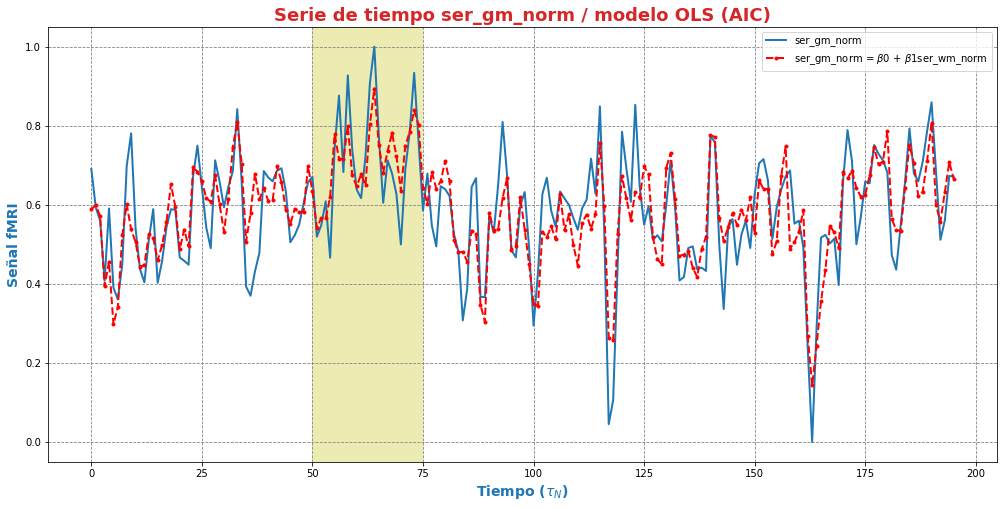

In [52]:
plot_series_osl(df_depen=df_gm, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo ser_gm_norm / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del modelo que menos se ajusta mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:            ser_gm_norm   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2768
Date:                Fri, 22 Jul 2022   Prob (F-statistic):              0.842
Time:                        11:03:02   Log-Likelihood:                 97.591
No. Observations:                 196   AIC:                            -187.2
Df Residuals:                     192   BIC:                            -174.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5465      0.070      7.764      

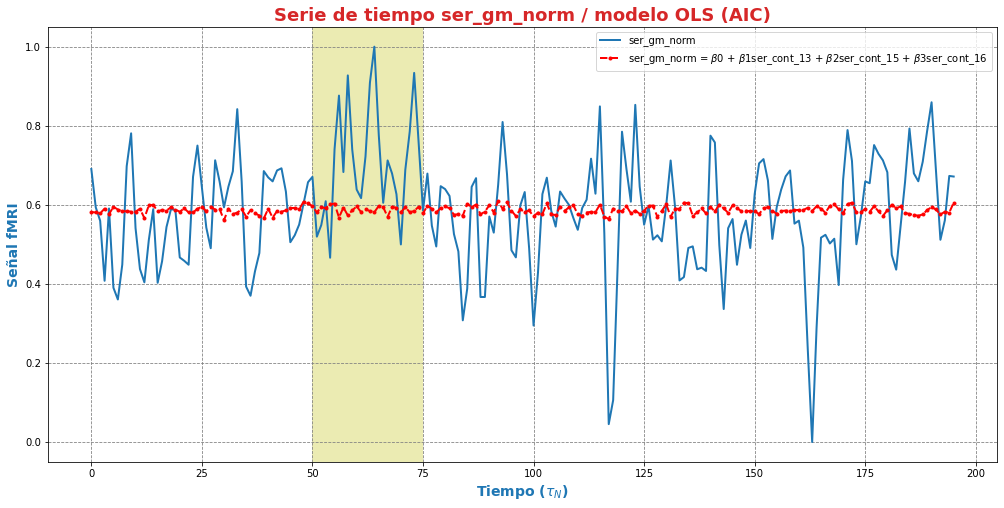

In [53]:
plot_series_osl(df_depen=df_gm, 
                models_osl=aic_all, 
                best=62, 
                titulo='Serie de tiempo ser_gm_norm / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [54]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

,MODELO,AIC,R2,R2-ajus
0,ser_wm_norm,-417.060000,0.685500,0.683900
1,"ser_wm_norm,ser_cont_14",-416.830000,0.688300,0.685100
2,"ser_wm_norm,ser_cont_13",-415.840000,0.686700,0.683500
3,"ser_wm_norm,ser_cont_16",-415.800000,0.686700,0.683400
4,"ser_wm_norm,ser_cont_14,ser_cont_16",-415.460000,0.689300,0.684500
5,"ser_wm_norm,ser_cont_13,ser_cont_14",-415.460000,0.689300,0.684500
6,"ser_csf_norm,ser_wm_norm",-415.410000,0.686000,0.682800
7,"ser_wm_norm,ser_cont_15",-415.240000,0.685800,0.682500
8,"ser_wm_norm,ser_cont_14,ser_cont_15",-415.030000,0.688600,0.683800
9,"ser_csf_norm,ser_wm_norm,ser_cont_14",-414.960000,0.688500,0.683700


## Tiempo de ejecución

In [55]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n\n', tiempo, 'seg\n', tiempo/60, 'min\n',      
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n\n', tiempo2, 'seg\n', tiempo2/60, 'min\n',   
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución

 10.093701839447021 seg
 0.1682283639907837 min
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU

 8.729252843 seg
 0.14548754738333333 min
 ---------------------------------------



## FIN